## Time Series Forecasting with Statsmodels and Prophet

In [66]:
# Core data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Time series analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter

# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Feature engineering
from sklearn.preprocessing import StandardScaler

In [67]:
# set Theme
sns.set_theme(style='whitegrid', palette='pastel')

In [68]:
## Import charge-off and recovery data
core_data = pd.read_csv('co_rec_data.csv',index_col=1,parse_dates=True)
core_data.rename(columns={' CO_BAL ': 'CO_BAL', ' REC_BAL ': 'REC_BAL'}, inplace=True)
core_data = pd.DataFrame(core_data)

## Clean data - drop unnecessary columns, set index to monthend data
core_data.drop(columns='SEQUENCE', inplace=True)
core_data.index.freq = 'Me'

# Set display for all rows and columns on print
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# set numeric value display - remove scientific notation and truncation
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Add ratio column
core_data['ratio'] = core_data['REC_BAL']/core_data['CO_BAL']

C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\2872207907.py:8: FutureWarning: 'Me' is deprecated and will be removed in a future version, please use 'ME' instead.
  core_data.index.freq = 'Me'


In [69]:
## Core functions will live at the top for later use

# general model fitting function
def fit_model(model_data, trend, seasonal, damped_trend, remove_bias, dataset_input, dataset_output, col, seasonal_periods=12, optimized=True):
    
    fitted_model = ExponentialSmoothing(
    model_data,
    trend=trend,           # Additive trend
    seasonal=seasonal,        # Multiplicative seasonality
    damped_trend=damped_trend,     # Damped trend
    seasonal_periods=seasonal_periods    # Monthly seasonality
    )

    # Fit with your best fitting parameters (use the ones that gave best results)
    fitted_model = fitted_model.fit(
        optimized=optimized,       # Let it optimize smoothing parameters
        remove_bias=remove_bias
    )

    fitted_values = fitted_model.fittedvalues

    dataset_output = dataset_input.merge(pd.DataFrame(fitted_values, columns=[col]), how='left', left_index=True, right_index=True)

    # Calculate in-sample metrics using sklearn
    mae = mean_absolute_error(model_data, fitted_values)
    rmse = np.sqrt(mean_squared_error(model_data, fitted_values))
    mse = mean_squared_error(model_data, fitted_values)

    # MAPE you'll still need to calculate manually
    mape = np.mean(np.abs((model_data - fitted_values) / model_data)) * 100

    # R-squared
    r2 = r2_score(model_data, fitted_values)

    return dataset_output, fitted_model, mae, rmse, mse, mape, r2

In [70]:
# print fitted model outputs for comparison of train and test versions
def print_output_fit_model(mae, mse, rmse, mape, r2):
    print(f"In-Sample Performance:")
    print(f"MAE: ${mae:,.0f}")
    print(f"MSE: ${mse:,.0f}")
    print(f"RMSE: ${rmse:,.0f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R-squared: {r2:.3f}")

In [71]:
# Split our data
def split_data(dataset_input, data_col, test_size):
    # Split your data
    train_name, test_name = train_test_split_ts(dataset_input[data_col], test_size=test_size)

    print(f"Train period: {train_name.index[0]} to {train_name.index[-1]}")
    print(f"Test period: {test_name.index[0]} to {test_name.index[-1]}")
    print(f"Train size: {len(train_name)} months")
    print(f"Test size: {len(test_name)} months")

    return train_name, test_name

In [72]:
# generalized plot for our data
def plot_data(title, data_input, col_prefix, label_prefix, legend_col, ylim, yticks, yticks_labels, 
              actual_data=True, trend_data = False, train_forecast=False, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False):
    # Plot Charge-Off and Recovery Data Together
    fig, ax = plt.subplots(figsize=(16,8))  # Changed this line


    plt.title(title, size=16, fontweight='bold', pad=32)  # Add pad for spacing

    # Plot CO data
    if actual_data == True:
        ax.plot(data_input.index, data_input['{}_BAL'.format(col_prefix)], color='blue', label='{}'.format(label_prefix))

    if trend_data == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend'.format(col_prefix)], color="#2ba0c4", linestyle="--", lw=2, label='{} Trend'.format(label_prefix))

    if train_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_train_forecast'.format(col_prefix)], color='green', linestyle="dotted", lw=3, label='{} Train Data Predictions'.format(label_prefix))
    
    if test_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_test_forecast'.format(col_prefix)], color='purple', linestyle="dotted", lw=3, label='{} Test Data Predictions'.format(label_prefix))

    if trend_train_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend_train_forecast'.format(col_prefix)], color='green', linestyle="dotted", lw=3, label='{} Trend Train Data Predictions'.format(label_prefix))

    
    if trend_test_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend_test_forecast'.format(col_prefix)], color='purple', linestyle="dotted", lw=3, label='{} Trend Test Data Predictions'.format(label_prefix))

    if trend_ci == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend_upper'.format(col_prefix)], color='#a7c8d2', alpha=0.5, lw=1)
        ax.plot(data_input.index, data_input['{}_BAL_trend_lower'.format(col_prefix)], color='#a7c8d2', alpha=0.5, lw=1)
        ax.fill_between(data_input.index.values, data_input['{}_BAL_trend_lower'.format(col_prefix)], data_input['{}_BAL_trend_upper'.format(col_prefix)], facecolor='#a7c8d2', alpha=0.3)

    ax.autoscale(axis='x',tight=True)
    ax.set_ylabel('Balance ($)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks_labels, fontsize=12)
    ax.tick_params(axis='x', size=12)
    # Position legend between title and plot
    plt.legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=legend_col, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(0, ylim)
    plt.show();

In [73]:
# forecasting data for testing
def forecast_data(fitted_model, data_input, forecast_data, col_prefix, trend=False):
    # Generate stable forecasts
    forecast = fitted_model.forecast(len(forecast_data))

    if trend==False:
        data_input = data_input.merge(pd.DataFrame(forecast, columns=['{}_BAL_test_forecast'.format(col_prefix)]), how='left', left_index=True, right_index=True)
    if trend==True:
        data_input = data_input.merge(pd.DataFrame(forecast, columns=['{}_BAL_trend_test_forecast'.format(col_prefix)]), how='left', left_index=True, right_index=True)

    print(f"📊 STABLE RECOVERY FORECAST RESULTS:")
    print(f"Actual mean: ${forecast_data.mean():,.0f}")
    print(f"Stable forecast mean: ${forecast.mean():,.0f}")
    print(f"Ratio: {forecast.mean() / forecast_data.mean():.2f}x")

    # Calculate performance
    stable_mape = np.mean(np.abs((forecast_data - forecast) / forecast_data)) * 100
    stable_r2 = r2_score(forecast_data, forecast)

    print(f"MAPE: {stable_mape:.2f}%")
    print(f"R²: {stable_r2:.3f}")

    return data_input

In [74]:

# 1) EDA Phase of testing the data - DickFuller, correlation, structural breaks?
# 2) Start by Charting our data
# ?? Then add a linear regression line
# 3) Then add a hpfilter to generate a general trend
# ?? Run rsme, error bands and what else?
# 4) Run forecast on data, but test it? how close of prediction can it make?
# 5) Build out Lag function and leverage XGBoost - How much closer does it get?
# 6) Conclusion should be leveraging the best portfolio estimates and why?

#### 1 EDA Analysis

##### 1.1 Data Overview and Quality Assessment

In [75]:
# Basic data exploration
print("Dataset Info:")
print(f"Shape: {core_data.shape}")
print(f"Date range: {core_data.index.min()} to {core_data.index.max()}")
print(f"Frequency: {core_data.index.freq}")

# Summary statistics
print("\nSummary Statistics:")
print(core_data.describe())

Dataset Info:
Shape: (78, 3)
Date range: 2019-01-31 00:00:00 to 2025-06-30 00:00:00
Frequency: <MonthEnd>

Summary Statistics:
            CO_BAL     REC_BAL   ratio
count      78.0000     78.0000 78.0000
mean   705805.4518 200030.0477  0.3382
std    325979.6360  78735.2323  0.1702
min    229725.8600  81280.6600  0.0780
25%    415467.9925 142716.8100  0.1996
50%    659982.9750 186885.6000  0.3121
75%    929631.3325 239869.0550  0.4497
max   1430176.6500 533885.7400  0.8220


Comment on the data

##### 1.2 Stationary Testing

In [76]:
def stationarity_test(series, title):
    """Comprehensive stationarity analysis"""
    print(f"\n=== Stationarity Test: {title} ===")
    
    # Acore_data Test
    acore_data_result = adfuller(series.dropna())
    print(f"Acore_data Statistic: {acore_data_result[0]:.6f}")
    print(f"p-value: {acore_data_result[1]:.6f}")
    print("Critical Values:")
    for key, value in acore_data_result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if acore_data_result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")
    
    return acore_data_result[1] <= 0.05

# Test both series
charge_off_stationary = stationarity_test(core_data['CO_BAL'], 'Charge-offs')
recovery_stationary = stationarity_test(core_data['REC_BAL'], 'Recoveries')


=== Stationarity Test: Charge-offs ===
Acore_data Statistic: 0.675456
p-value: 0.989335
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590
✗ Series is non-stationary (fail to reject null hypothesis)

=== Stationarity Test: Recoveries ===
Acore_data Statistic: -7.295327
p-value: 0.000000
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587
✓ Series is stationary (reject null hypothesis)


Comment on the output

##### 1.3 Seasonality & Decomposition Analysis

Charge-offs Seasonality Strength: 0.306
Recoveries Seasonality Strength: 0.367


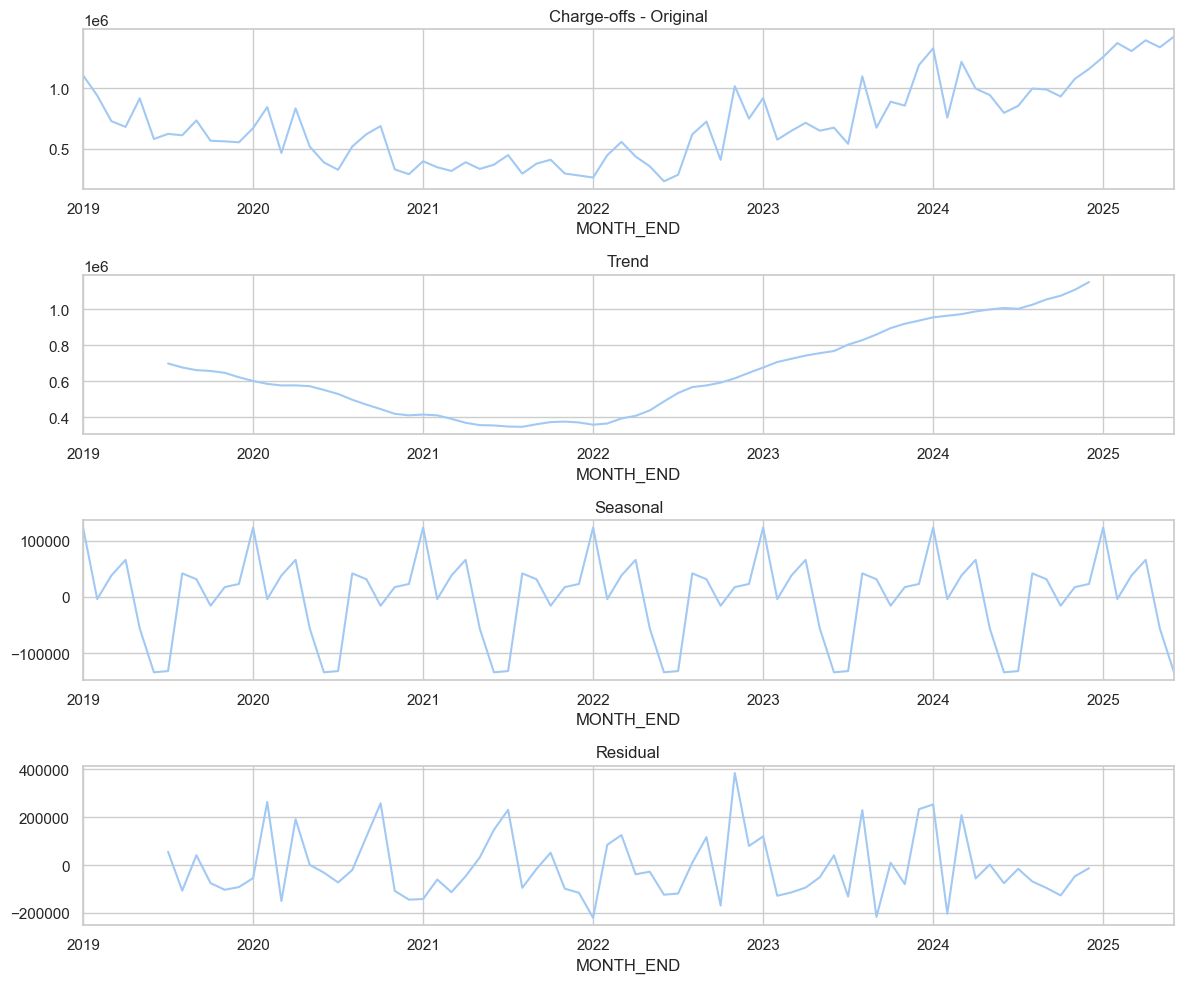

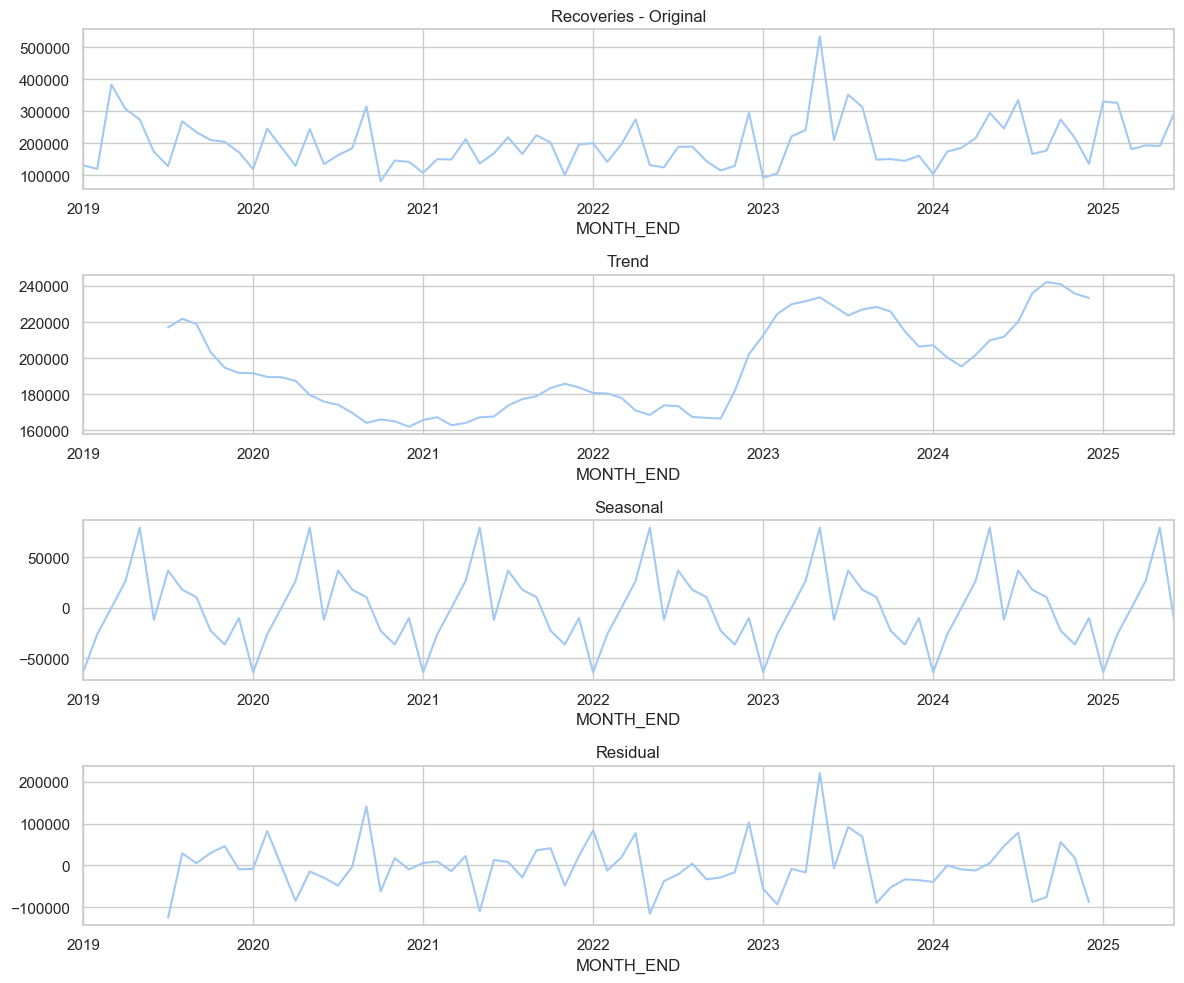

In [77]:
# Seasonal decomposition
def analyze_seasonality(series, title, period=12):
    """Decompose time series into trend, seasonal, residual"""
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=axes[0], title=f'{title} - Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    
    # Seasonality strength
    seasonal_strength = np.var(decomposition.seasonal.dropna()) / np.var(decomposition.resid.dropna())
    print(f"{title} Seasonality Strength: {seasonal_strength:.3f}")
    
    return decomposition

# Apply to your data
charge_decomp = analyze_seasonality(core_data['CO_BAL'], 'Charge-offs')
recovery_decomp = analyze_seasonality(core_data['REC_BAL'], 'Recoveries')

#### 1.4 Correlation Analysis & Outlier Detection

In [78]:
# Establish year for label
core_data['year'] = core_data.index.year
# Define colors for each year
years = sorted(core_data['year'].unique())
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(years)))

In [79]:
# Outlier detection
def detect_outliers(series, method='iqr', threshold=1.5):
    """Detect outliers using IQR or Z-score method"""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]
    else:  # z-score
        z_scores = np.abs((series - series.mean()) / series.std())
        outliers = series[z_scores > threshold]
    
    return outliers, lower_bound, upper_bound

co_outliers, co_lower_bound, co_upper_bound = detect_outliers(core_data['CO_BAL'])
rec_outliers, rec_lower_bound, rec_upper_bound = detect_outliers(core_data['REC_BAL'])

print(f"Charge-off outliers: {len(co_outliers)}")
print(f"Recovery outliers: {len(rec_outliers)}")

Charge-off outliers: 0
Recovery outliers: 1


In [80]:
outlier_x = float(core_data['CO_BAL'][core_data['REC_BAL'] == max(core_data['REC_BAL'])])
outlier_y = max(core_data['REC_BAL'])

C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\1462304157.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  outlier_x = float(core_data['CO_BAL'][core_data['REC_BAL'] == max(core_data['REC_BAL'])])


C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\391925632.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(year_data['CO_BAL'], year_data['REC_BAL'],


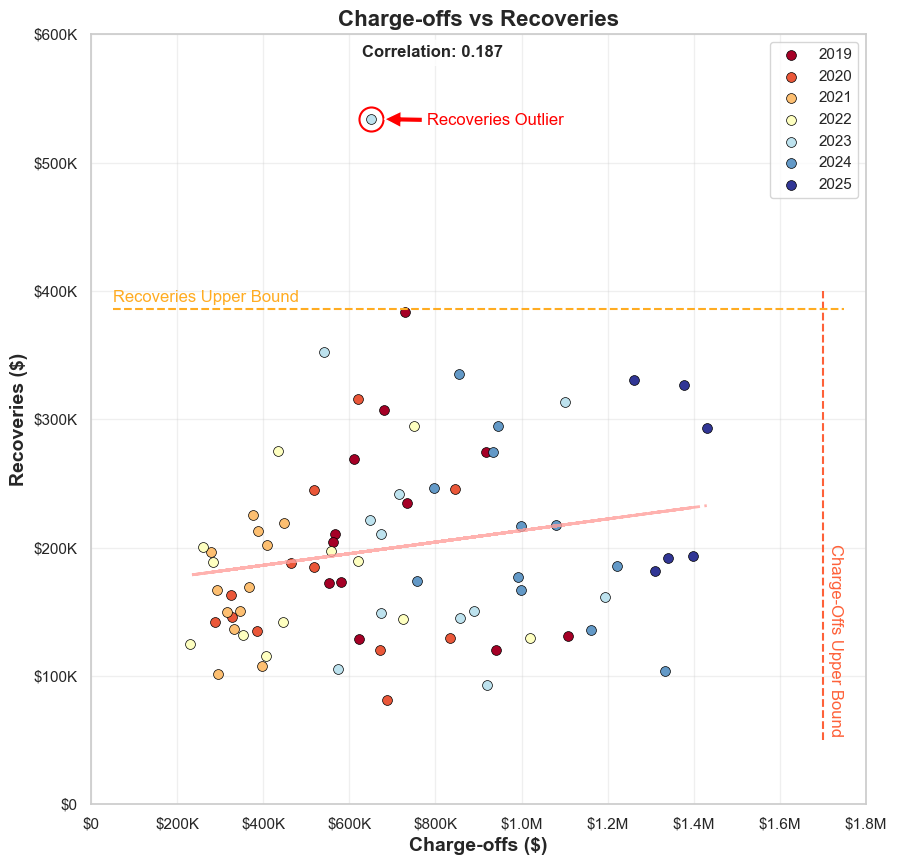

In [81]:
fig = plt.figure(figsize = (10, 10))


# Mark outlier
plt.scatter(outlier_x,
            outlier_y,
            facecolor= 'white',   # Color inside the marker
            edgecolors='red',    # Color of the outline
            linewidths=1.5,        # Width of the outline
            s=300,
            label='_Hidden') 
plt.annotate('Recoveries Outlier',  # Changed from 'axes fraction' to descriptive text
            xy=(outlier_x + 30000, outlier_y), xycoords='data',  # Point to annotate
            xytext=(outlier_x + 130000, outlier_y-6500), textcoords='data',  # Changed to data coordinates
            arrowprops=dict(facecolor='red', shrink=0.02),
            color='red', 
            horizontalalignment='left', verticalalignment='bottom')
# Color-code by time period to see if relationship changes
# Plot each year separately to create legend
for i, year in enumerate(years):
    year_data = core_data[core_data['year'] == year]
    plt.scatter(year_data['CO_BAL'], year_data['REC_BAL'], 
               c=colors[i], edgecolors= 'black', linewidths = 0.5,
               s=50, label=str(year))

#plt.colorbar(scatter, label='Time Period')
plt.legend(loc=0)
plt.xlabel('Charge-offs ($)', fontsize=14, fontweight='bold')
plt.xticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'])
plt.yticks([0, 100000, 200000, 300000, 400000, 500000, 600000], 
              ['$0', '$100K', '$200K', '$300K', '$400K', '$500K', '$600K'])
plt.ylabel('Recoveries ($)', fontsize=14, fontweight='bold')
plt.title('Charge-offs vs Recoveries', fontsize=16, fontweight='bold')

# Add trend line
z = np.polyfit(core_data['CO_BAL'], core_data['REC_BAL'], 1)
p = np.poly1d(z)
plt.plot(core_data['CO_BAL'], p(core_data['CO_BAL']), "r--", alpha=0.8, linewidth=2)

# Add upper and lower band for charge-offs
plt.plot([co_upper_bound, co_upper_bound], [50000, 400000], linestyle = "--", color =  "#fe6139") #upper bound
plt.plot([co_lower_bound, co_lower_bound], [50000, 400000], linestyle = "--", color =  "#fe6139") #lower bound is less than 0
plt.text(co_upper_bound + 10000, 55000, "Charge-Offs Upper Bound", rotation=-90,color="#fe6139")
# Add upper and lower band for recoveries
plt.plot([50000, 1750000], [rec_upper_bound, rec_upper_bound], linestyle = "--", color = "#ffac22") #upper bound
plt.plot([50000, 1750000], [rec_lower_bound, rec_lower_bound], linestyle = "--", color = "#ffac22") #lower bound is less than 0
plt.text(50000, rec_upper_bound + 6000, "Recoveries Upper Bound",color="#ffac22")


correlation = core_data['CO_BAL'].corr(core_data['REC_BAL'])
plt.text(0.35, 0.97, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, fontweight= 'semibold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.grid(True, alpha=0.3)
plt.xlim(0, 1800000)
plt.ylim(0, 600000)
plt.show()

In [82]:
# Correlation by Year
for i in years:
    correlation = core_data['CO_BAL'][core_data['year'] == i].corr(core_data['REC_BAL'][core_data['year'] == i])
    print('{}: {}'.format(i, round(correlation, 3)))
    

2019: -0.162
2020: 0.135
2021: 0.425
2022: 0.09
2023: -0.238
2024: -0.613
2025: -0.059


#### 2) Plot our Data for Visual Analysis

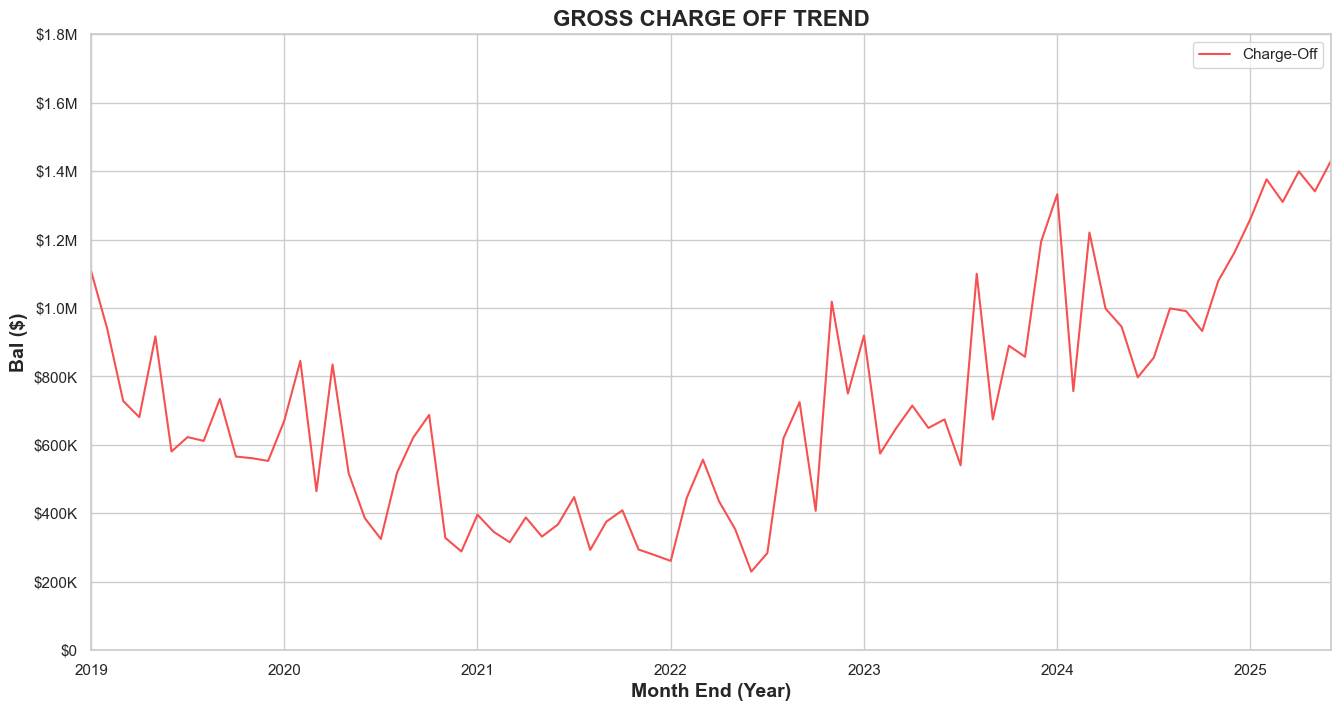

In [83]:
# Plot Gross Charge-Off Data
ax = core_data['CO_BAL'].plot(figsize=(16,8), color='#f75050')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M']);
plt.legend(['Charge-Off'], loc=0)
plt.ylim(0, 1800000)
plt.title('GROSS CHARGE OFF TREND', size=16, fontweight = 'bold')
plt.show();

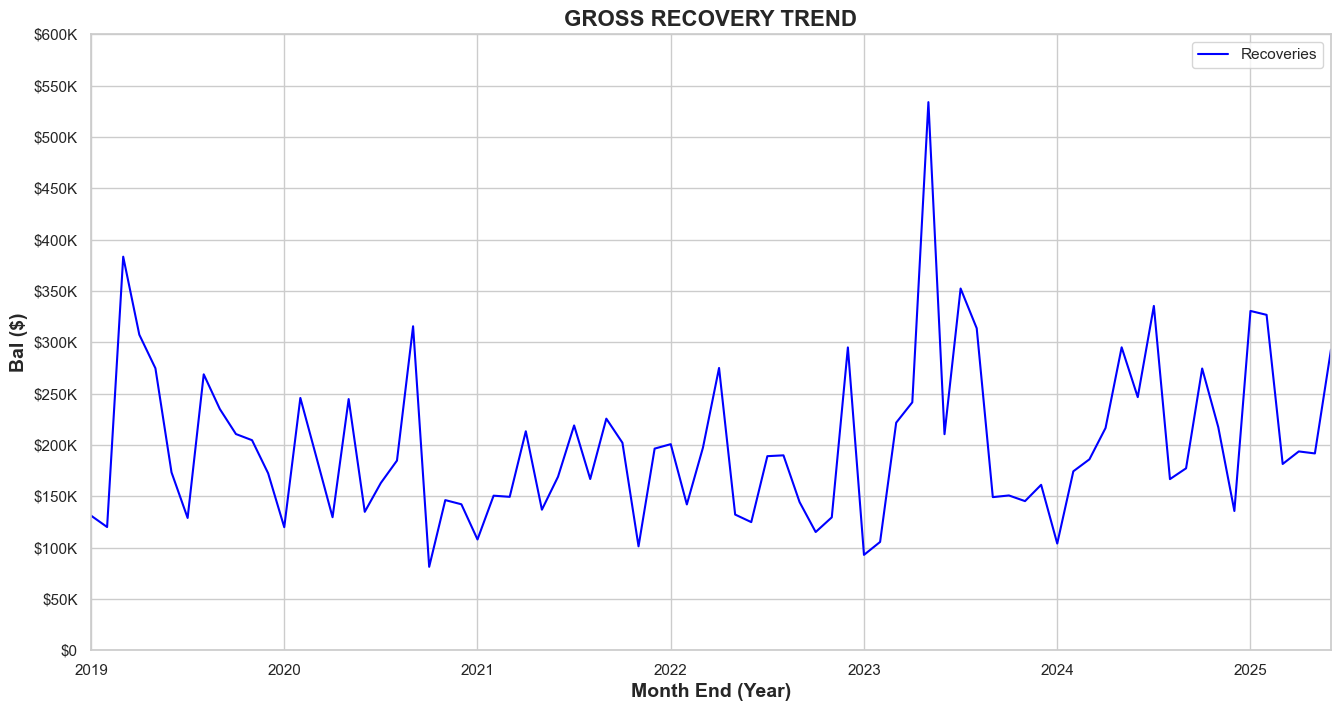

In [84]:
# Plot Recovery Data
ax = core_data['REC_BAL'].plot(figsize=(16,8), color='blue')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000], 
              ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']);
plt.legend(['Recoveries'], loc=0)
plt.ylim(0, 600000)
plt.title('GROSS RECOVERY TREND', size = 16, fontweight='bold')
plt.show();

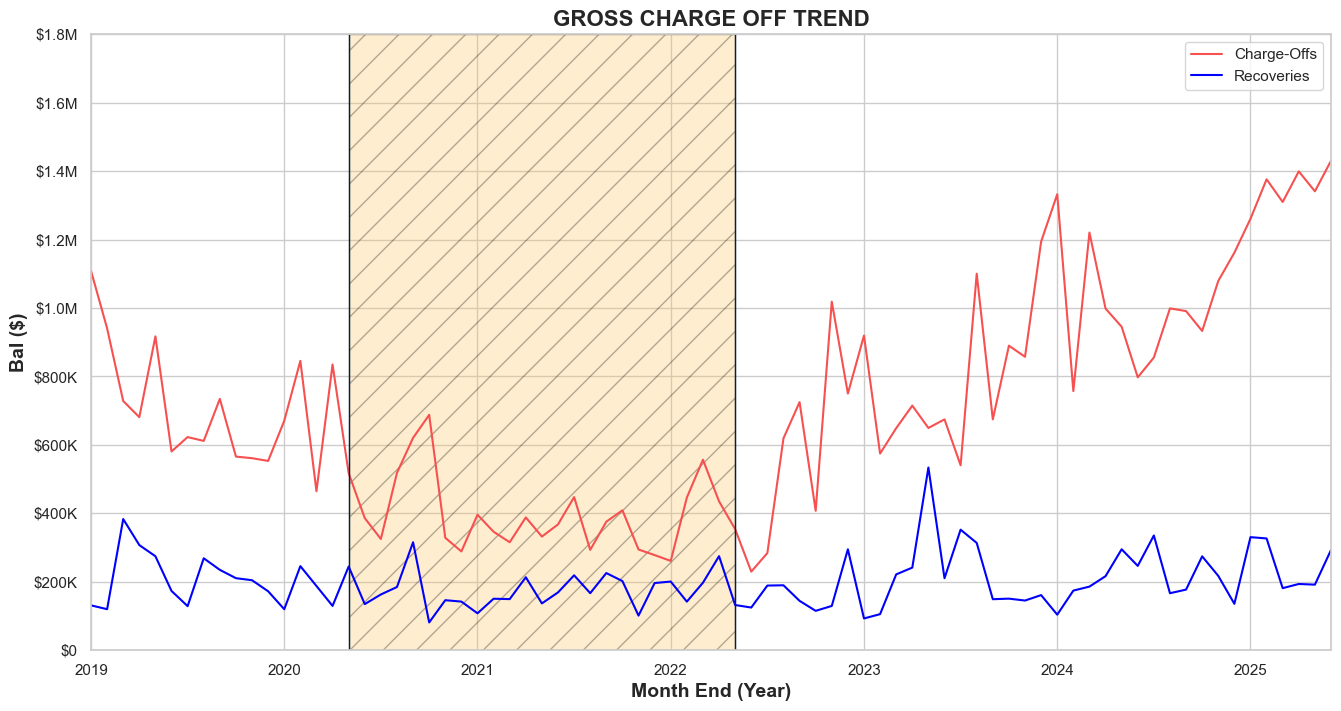

In [85]:
# Plot Charge-Off and Recovery Data Together
ax = core_data['CO_BAL'].plot(figsize=(16,8), color='#f75050', label= 'Charge-Offs')
ax = core_data['REC_BAL'].plot(figsize=(16,8), color='blue', label= 'Recoveries')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'])

ax.axvspan('5/31/2020', '5/31/2022', alpha=0.3, hatch = "/", facecolor='#ffc561', edgecolor='black')
ax.vlines("5/31/2020", ymin=0, ymax=1800000, color= '#002147', lw=1)
ax.vlines("5/31/2022", ymin=0, ymax=1800000, color= '#002147', lw=1)

plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('GROSS CHARGE OFF TREND', size=16, fontweight = 'bold')
plt.show();

In [86]:
def ratio_predictions(data):
    data['Time_Elapsed'] = np.arange(0, len(data), 1)
    X = data[['Time_Elapsed']]
    y = data['ratio']
    model_rr = LinearRegression()
    model_rr.fit(X, y)
    predictions = model_rr.predict(X)
    data['Predictions'] = predictions.astype(float)

    return data

In [87]:
stable = core_data.iloc[0:16]
covid = core_data.iloc[16:41]
rate_increase = core_data.iloc[42:]

In [88]:
stable = ratio_predictions(stable)
covid = ratio_predictions(covid)
rate_increase = ratio_predictions(rate_increase)


C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\1434961255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Time_Elapsed'] = np.arange(0, len(data), 1)
C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\1434961255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predictions'] = predictions.astype(float)
C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\1434961255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\2518089973.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(stable.index, stable['Predictions'], "r--", color='tomato', linewidth=2, label= 'Trend Line')
C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\2518089973.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(covid.index, covid['Predictions'], "r--", color='tomato', linewidth=2, label='_Hidden')
C:\Users\iantm\AppData\Local\Temp\ipykernel_27884\2518089973.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(rate_increase.index, rate_increase['Predictions'], "r--", color='tomato', linewidth=2,label='_Hidden')


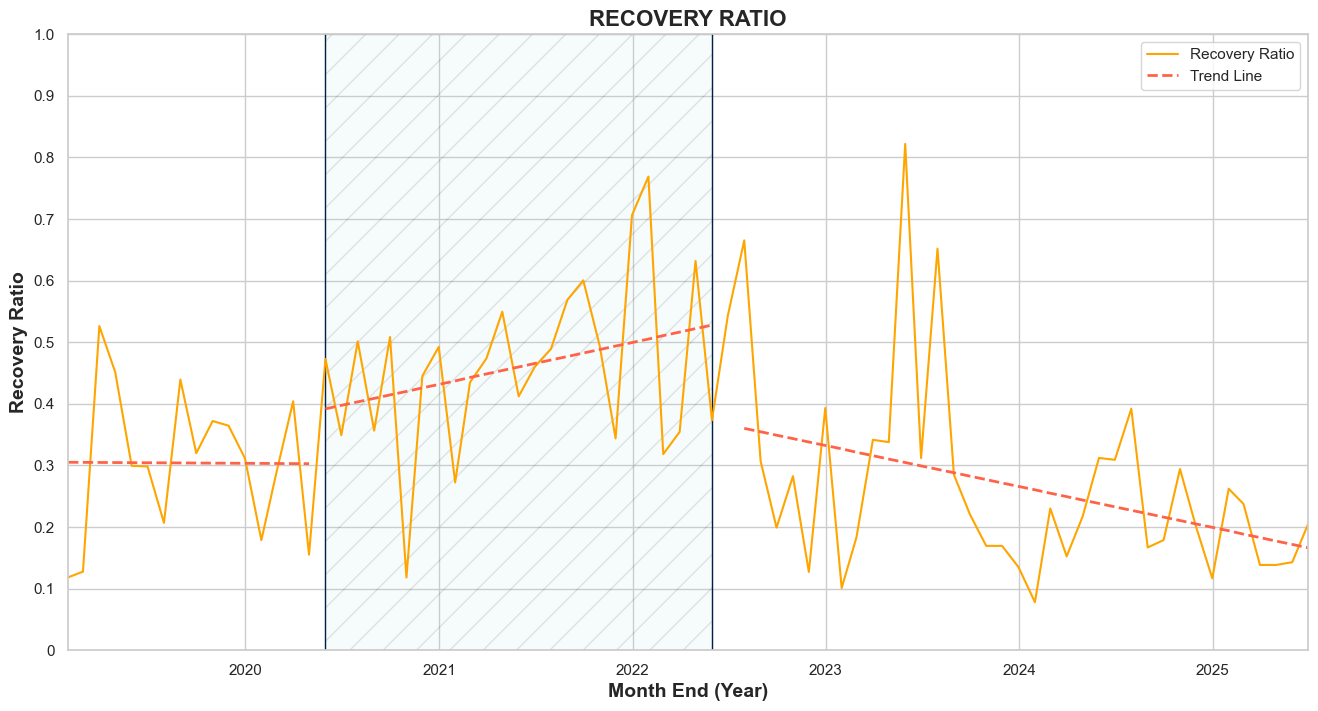

In [89]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-05-31')
end_date = pd.to_datetime('2022-05-31')

ax.axvspan(start_date, end_date, alpha=0.1, hatch = "/", facecolor="lightblue", edgecolor='black')
ax.vlines(start_date, ymin=0, ymax=1800000, color= '#002147', lw=1)
ax.vlines(end_date, ymin=0, ymax=1800000, color= '#002147', lw=1)

ax.plot(core_data.index, core_data['ratio'], color='orange', label='Recovery Ratio')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Recovery Ratio', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
              ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

ax.plot(stable.index, stable['Predictions'], "r--", color='tomato', linewidth=2, label= 'Trend Line')
ax.plot(covid.index, covid['Predictions'], "r--", color='tomato', linewidth=2, label='_Hidden')
ax.plot(rate_increase.index, rate_increase['Predictions'], "r--", color='tomato', linewidth=2,label='_Hidden')

plt.legend(loc=0)
plt.ylim(0, 1)
plt.title('RECOVERY RATIO', size=16, fontweight = 'bold')
plt.show();

Comment on the linear trend line shift

#### 3.0 Generate Charge-Off Exponential Trend Line

In [90]:
def hpfilter_trend_cycling(data, col, lamb):
    # Tuple unpacking for charge_offs
    cycle, trend = hpfilter(data[col], lamb=lamb)
    data['{}_trend'.format(col)] = trend
    # Calculate error bands using the cyclical component
    cycle_std = cycle.std()
    trend_upper = trend + (cycle_std * 1.96)
    trend_lower = trend - (cycle_std * 1.96)

    data['{}_trend_upper'.format(col)] = trend_upper
    data['{}_trend_lower'.format(col)] = trend_lower

    return data

In [91]:
core_trend_data = hpfilter_trend_cycling(core_data, 'CO_BAL', 1000)

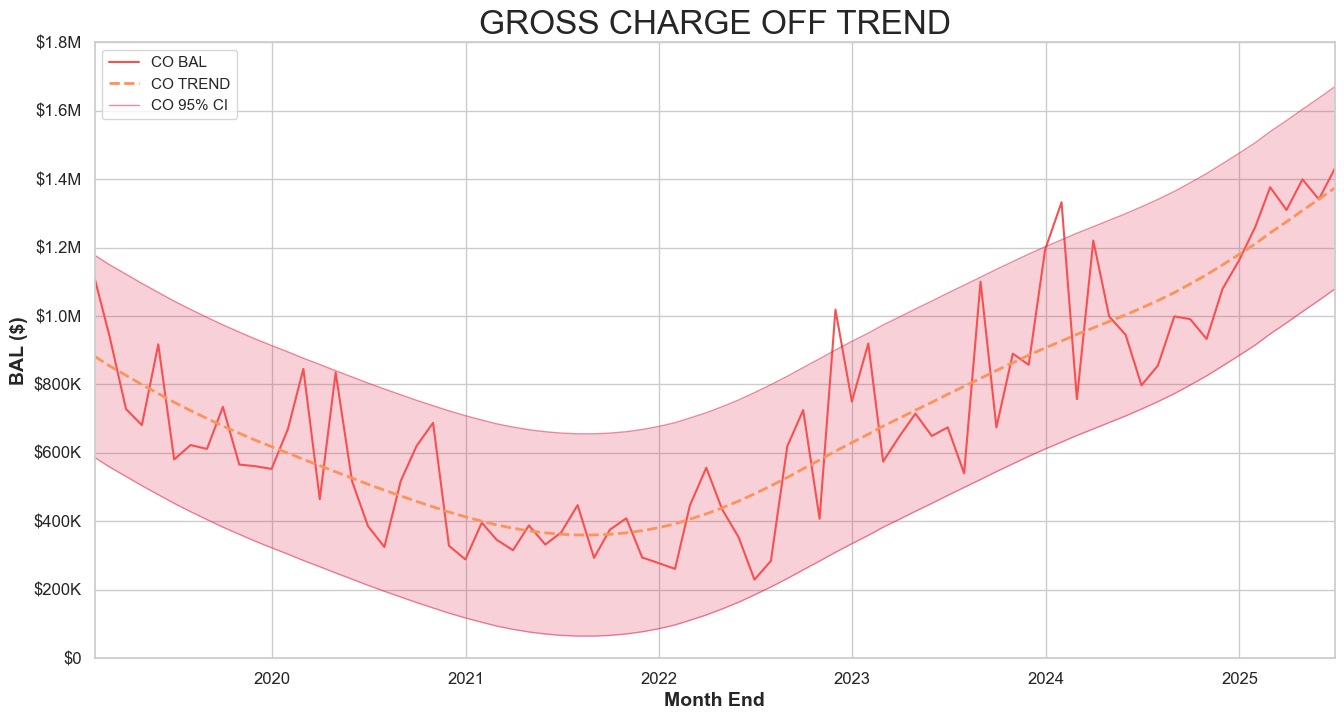

In [92]:
# Visualize the data

#CO_BAL CHART PRIOR TO FORECASTING
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

ax.plot(core_trend_data.index, core_trend_data['CO_BAL'], color='#f75050')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2)
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend_upper'], color='crimson', alpha=0.5, lw=1)
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend_lower'], color='crimson', alpha=0.5, lw=1)
ax.fill_between(core_trend_data.index.values, core_trend_data['CO_BAL_trend_lower'], core_trend_data['CO_BAL_trend_upper'], facecolor='crimson', alpha=0.2)
ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend(['CO BAL', 'CO TREND', 'CO 95% CI' ], loc=0)
plt.ylim(0, 1800000)
plt.title('GROSS CHARGE OFF TREND', size=24)
plt.show();

In [93]:
core_trend_data = hpfilter_trend_cycling(core_data, 'REC_BAL', 1000)

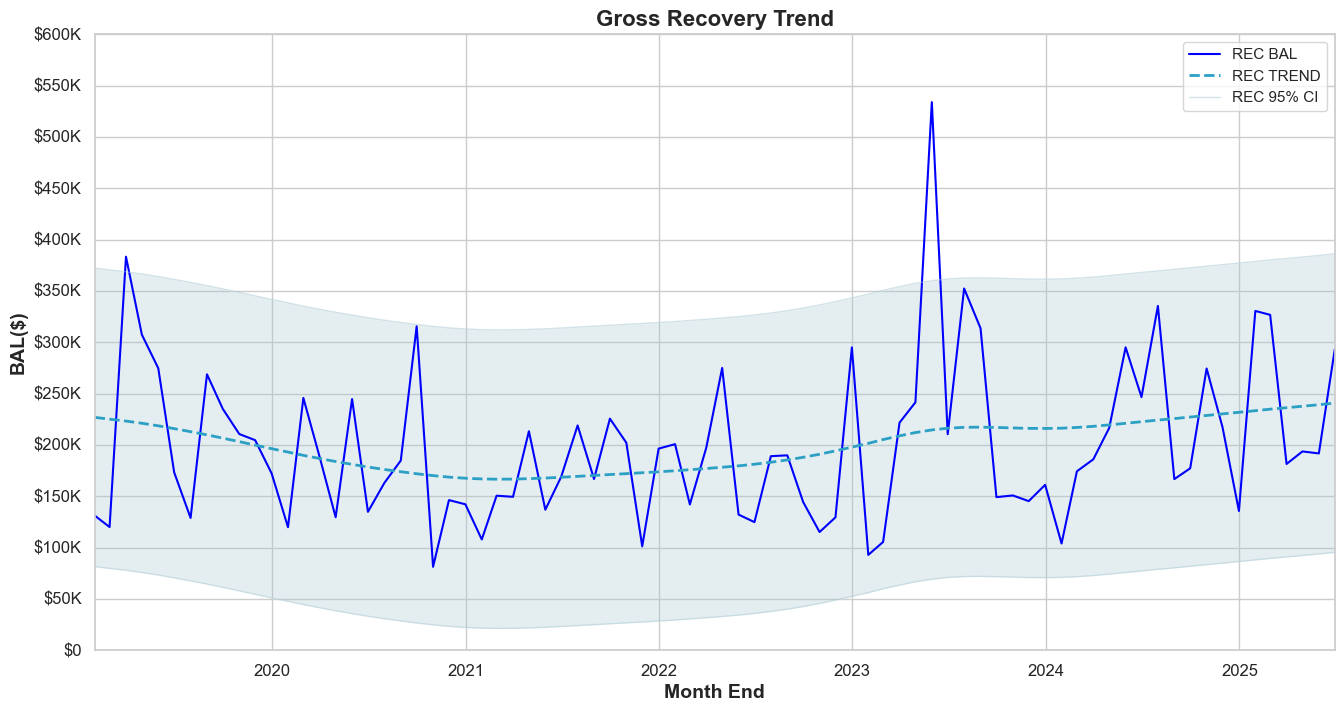

In [94]:
#REC_BAL CHART PRIOR TO FORECASTING
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

ax.plot(core_trend_data.index, core_trend_data['REC_BAL'], color='blue')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend'], color="#2ba0c4", linestyle="--", lw=2)
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend_upper'], color='#a7c8d2', alpha=0.5, lw=1)
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend_lower'], color='#a7c8d2', alpha=0.5, lw=1)
ax.fill_between(core_trend_data.index.values, core_trend_data['REC_BAL_trend_lower'], core_trend_data['REC_BAL_trend_upper'], facecolor='#a7c8d2', alpha=0.3)
ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000], 
              ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K'],
              fontsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.legend(['REC BAL', 'REC TREND', 'REC 95% CI' ], loc=0)
plt.ylim(0, 600000)
plt.title('Gross Recovery Trend', size = 16, fontweight='bold')
plt.show();

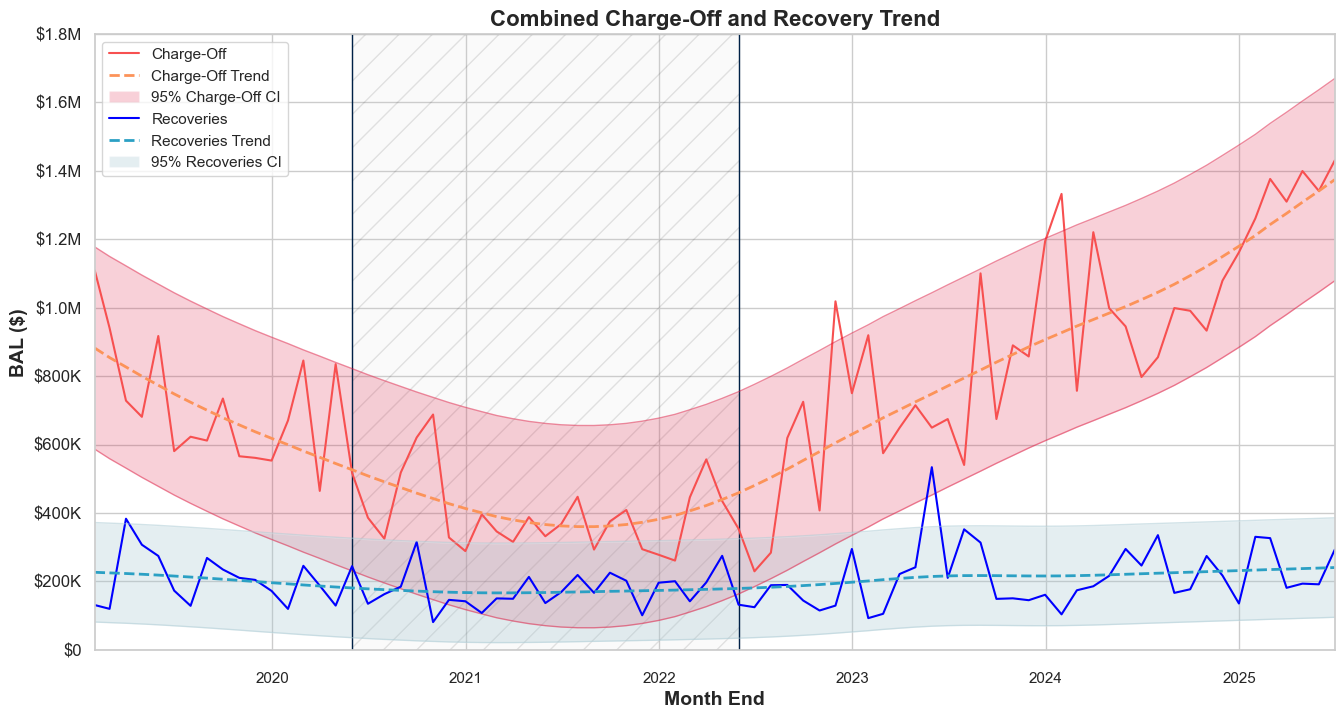

In [95]:
# Combined chart

# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-05-31')
end_date = pd.to_datetime('2022-05-31')

ax.axvspan(start_date, end_date, alpha=0.1, hatch = "/", facecolor="lightgrey", edgecolor='black')
ax.vlines(start_date, ymin=0, ymax=1800000, color= '#002147', lw=1)
ax.vlines(end_date, ymin=0, ymax=1800000, color= '#002147', lw=1)

# Plot CO data
ax.plot(core_trend_data.index, core_trend_data['CO_BAL'], color='#f75050', label='Charge-Off')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2, label='Charge-Off Trend')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend_upper'], color='crimson', alpha=0.5, lw=1, label='_Hidden')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend_lower'], color='crimson', alpha=0.5, lw=1, label='_Hidden')
ax.fill_between(core_trend_data.index.values, core_trend_data['CO_BAL_trend_lower'], core_trend_data['CO_BAL_trend_upper'], 
                facecolor='crimson', alpha=0.2, label='95% Charge-Off CI')

# Plot Recovery Data
ax.plot(core_trend_data.index, core_trend_data['REC_BAL'], color='blue', label='Recoveries')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend'], color="#2ba0c4", linestyle="--", lw=2, label='Recoveries Trend')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend_upper'], color='#a7c8d2', alpha=0.5, lw=1, label='_Hidden')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend_lower'], color='#a7c8d2', alpha=0.5, lw=1, label='_Hidden')
ax.fill_between(core_trend_data.index.values, core_trend_data['REC_BAL_trend_lower'], core_trend_data['REC_BAL_trend_upper'], 
                facecolor='#a7c8d2', alpha=0.3, label='95% Recoveries CI')

ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', size=12)
plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('Combined Charge-Off and Recovery Trend', size=16, fontweight='bold')
plt.show();

#### 4.0 Forecast Balances with Holtwinters Exponential Smoothing

In [96]:
# For final model evaluation - simple train/test split
def train_test_split_ts(data, test_size=12):
    """
    Simple train/test split for time series
    """
    train_size = len(data) - test_size
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    return train_data, test_data

# Split your data
train_data_co, test_data_co = train_test_split_ts(core_data['CO_BAL'], test_size=12)

print(f"Train period: {train_data_co.index[0]} to {train_data_co.index[-1]}")
print(f"Test period: {test_data_co.index[0]} to {test_data_co.index[-1]}")
print(f"Train size: {len(train_data_co)} months")
print(f"Test size: {len(test_data_co)} months")

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months


In [97]:
#Fit the Model
fitted_model = ExponentialSmoothing(train_data_co, 
                                        trend = 'mul', 
                                        seasonal = 'mul', 
                                        damped_trend = True,
                                        seasonal_periods=12).fit()

In [98]:
fitted_values = fitted_model.fittedvalues

In [99]:
# Calculate in-sample metrics using sklearn
train_mae = mean_absolute_error(train_data_co, fitted_values)
train_rmse = np.sqrt(mean_squared_error(train_data_co, fitted_values))
train_mse = mean_squared_error(train_data_co, fitted_values)

# MAPE you'll still need to calculate manually (not in sklearn)
train_mape = np.mean(np.abs((train_data_co - fitted_values) / train_data_co)) * 100

print(f"In-Sample Performance:")
print(f"MAE: ${train_mae:,.0f}")
print(f"MSE: ${train_mse:,.0f}")
print(f"RMSE: ${train_rmse:,.0f}")
print(f"MAPE: {train_mape:.2f}%")

# R-squared
train_r2 = r2_score(train_data_co, fitted_values)
print(f"R-squared: {train_r2:.3f}")

In-Sample Performance:
MAE: $117,820
MSE: $22,551,574,985
RMSE: $150,172
MAPE: 21.08%
R-squared: 0.675


In [100]:
# Parameter grid
trend_options = [None, 'add', 'mul']
seasonal_options = [None, 'add', 'mul'] 
damped_trend_options = [True, False]
seasonal_period = [12]

optimized_tf = [True, False]
remove_bias_tf = [True, False]
use_brute_tf = [True, False]

# Generate all combinations
param_combinations = list(itertools.product(trend_options, 
                                            seasonal_options, 
                                            damped_trend_options,
                                            seasonal_period
                                            ))
    

for trend, seasonal, damped, periods in param_combinations:
   # Skip invalid combinations
   if seasonal is None and damped:
            continue
   if trend is None and damped:
            continue
   
    # Fit model
   model = ExponentialSmoothing(
                    train_data_co,
                    trend=trend,
                    seasonal=seasonal,
                    damped_trend=damped,
                    seasonal_periods=periods
                )
   
   fitted_model = model.fit(
                  optimized=True
            )
   # Check if model fit was successful
   if fitted_model is None:
      raise ValueError("Model fit returned None")
   
   fitted_values = fitted_model.fittedvalues

   train_r2 = r2_score(train_data_co, fitted_values)
   train_mape = np.mean(np.abs((train_data_co - fitted_values) / train_data_co)) * 100

   print("HYPERPARAMETERS: Trend: {} | Seasonal: {} | Damped: {} || RESULTS: R-squared: {} | MAPE: {}%".format(
      trend, seasonal, damped, round(train_r2, 4), round(train_mape, 4)
   ))

HYPERPARAMETERS: Trend: None | Seasonal: None | Damped: False || RESULTS: R-squared: 0.5091 | MAPE: 25.205%
HYPERPARAMETERS: Trend: None | Seasonal: add | Damped: False || RESULTS: R-squared: 0.5978 | MAPE: 23.6298%
HYPERPARAMETERS: Trend: None | Seasonal: mul | Damped: False || RESULTS: R-squared: 0.6297 | MAPE: 22.4473%
HYPERPARAMETERS: Trend: add | Seasonal: None | Damped: False || RESULTS: R-squared: 0.5154 | MAPE: 23.4655%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: True || RESULTS: R-squared: 0.6307 | MAPE: 22.2292%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: False || RESULTS: R-squared: 0.5977 | MAPE: 22.0661%
HYPERPARAMETERS: Trend: add | Seasonal: mul | Damped: True || RESULTS: R-squared: 0.6708 | MAPE: 20.7343%
HYPERPARAMETERS: Trend: add | Seasonal: mul | Damped: False || RESULTS: R-squared: 0.6703 | MAPE: 20.6449%
HYPERPARAMETERS: Trend: mul | Seasonal: None | Damped: False || RESULTS: R-squared: 0.5261 | MAPE: 22.9654%
HYPERPARAMETERS: Trend: mul | Seas

In [101]:
# Fit your optimal Holt-Winters model
print("🎯 FITTING OPTIMAL HOLT-WINTERS MODEL")
print("Configuration: trend='add', seasonal='mul', damped_trend=True")

🎯 FITTING OPTIMAL HOLT-WINTERS MODEL
Configuration: trend='add', seasonal='mul', damped_trend=True


Not significant improvement, however the MAPE decreases to: 
"HYPERPARAMETERS: Trend: add | Seasonal: mul | Damped: True || RESULTS: R-squared: 0.6708 | MAPE: 20.7343%"

#### Run fitted model

In [102]:
optimal_model = ExponentialSmoothing(
    train_data_co,
    trend='add',           # Additive trend
    seasonal='mul',        # Multiplicative seasonality
    damped_trend=True,     # Damped trend
    seasonal_periods=12    # Monthly seasonality
)

# Fit with your best fitting parameters (use the ones that gave best results)
optimal_fitted_model = optimal_model.fit(
    optimized=True       # Let it optimize smoothing parameters
)

In [103]:
# Generate forecasts (simple method)
fitted_values = optimal_fitted_model.fittedvalues

In [104]:
core_forecast_data = core_trend_data.merge(pd.DataFrame(fitted_values, columns=['CO_BAL_train_forecast']), how='left', left_index=True, right_index=True)

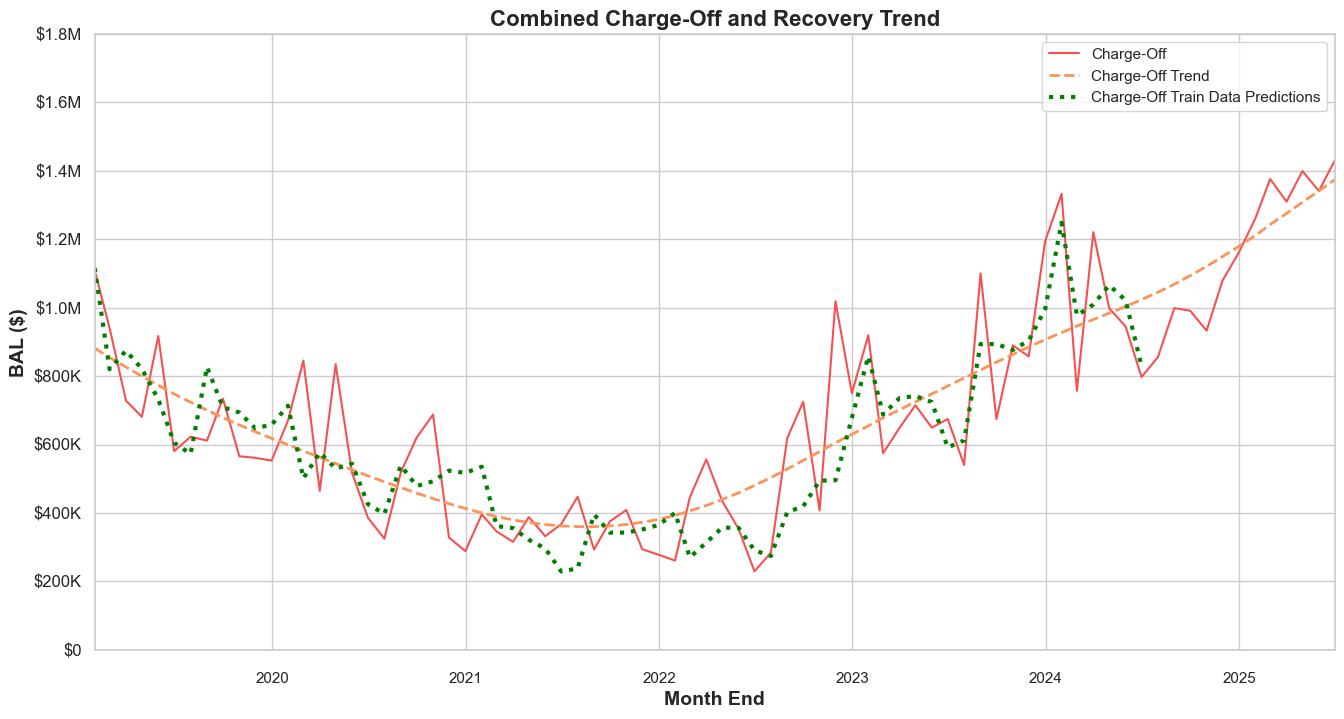

In [105]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Plot CO data
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL'], color='#f75050', label='Charge-Off')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2, label='Charge-Off Trend')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_train_forecast'], color='green', linestyle="dotted", lw=3, label='Charge-Off Train Data Predictions')


ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', size=12)
plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('Combined Charge-Off and Recovery Trend', size=16, fontweight='bold')
plt.show();

In [106]:
average_train_data = core_forecast_data[core_forecast_data.notna()]['CO_BAL'].mean()
std_train_data = core_forecast_data[core_forecast_data.notna()]['CO_BAL'].std()

average_train_forecast_data = core_forecast_data[core_forecast_data.notna()]['CO_BAL_train_forecast'].mean()
std_train_forecast_data = core_forecast_data[core_forecast_data.notna()]['CO_BAL_train_forecast'].std()

print("Mean Training Data: ${:,.2f}".format(average_train_data))
print("Std Dev of Training Data: ${:,.2f}".format(std_train_data))
print("Mean Fitted Values: ${:,.2f}".format(average_train_forecast_data))
print("Std Dev Fitted Values: ${:,.2f}".format(std_train_forecast_data))


Mean Training Data: $705,805.45
Std Dev of Training Data: $325,979.64
Mean Fitted Values: $604,178.65
Std Dev Fitted Values: $247,486.21


In [107]:
forecast_periods = len(test_data_co)
forecast = optimal_fitted_model.forecast(forecast_periods)

# Calculate in-sample metrics using sklearn
test_mae = mean_absolute_error(test_data_co, forecast)
test_rmse = np.sqrt(mean_squared_error(test_data_co, forecast))
test_mse = mean_squared_error(test_data_co, forecast)

# MAPE you'll still need to calculate manually (not in sklearn)
test_mape = np.mean(np.abs((test_data_co - forecast) / test_data_co)) * 100

print(f"In-Sample Performance:")
print(f"MAE: ${test_mae:,.0f}")
print(f"MSE: ${test_mse:,.0f}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"MAPE: {test_mape:.2f}%")

# R-squared
test_r2 = r2_score(test_data_co, forecast)
print(f"R-squared: {test_r2:.3f}")


In-Sample Performance:
MAE: $170,172
MSE: $40,031,163,843
RMSE: $200,078
MAPE: 14.38%
R-squared: -0.082


In [108]:
core_forecast_data = core_forecast_data.merge(pd.DataFrame(forecast, columns=['CO_BAL_test_forecast']), how='left', left_index=True, right_index=True)

Text(0.5, 1.0, 'Combined Charge-Off and Recovery Trend')

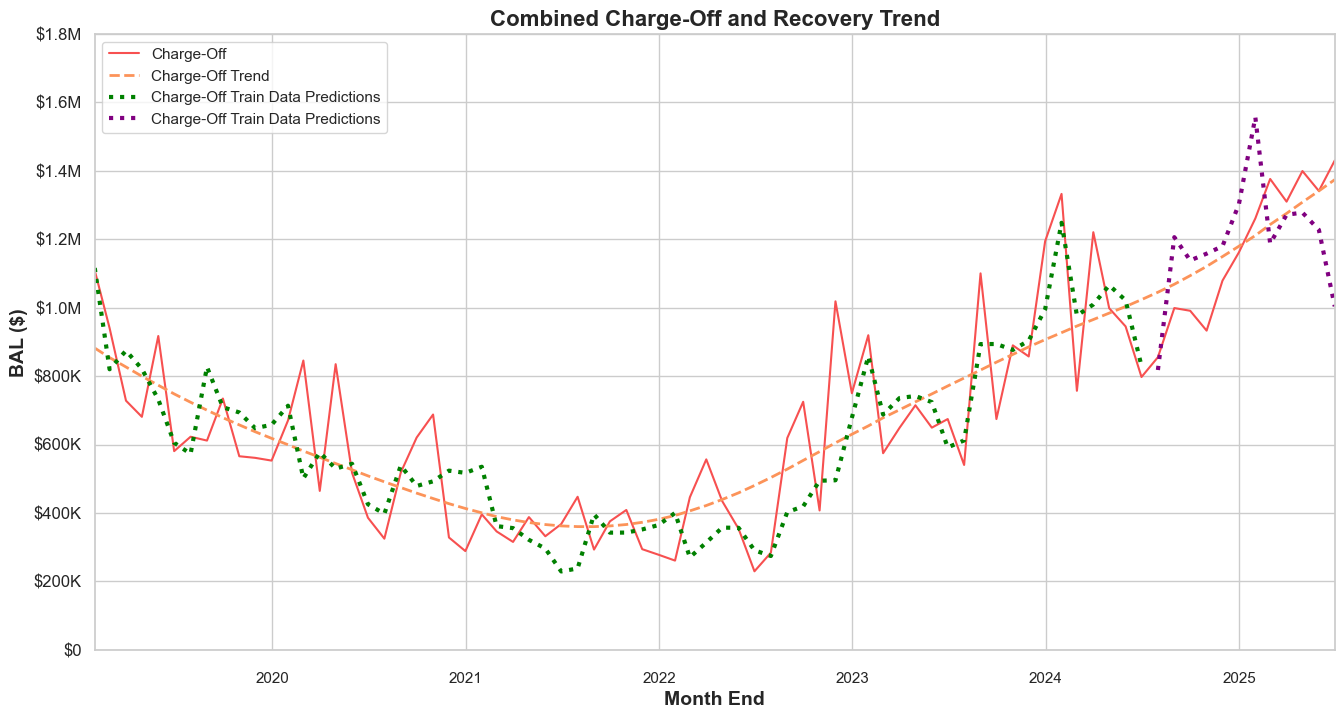

In [109]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Plot CO data
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL'], color='#f75050', label='Charge-Off')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2, label='Charge-Off Trend')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_train_forecast'], color='green', linestyle="dotted", lw=3, label='Charge-Off Train Data Predictions')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_test_forecast'], color='purple', linestyle="dotted", lw=3, label='Charge-Off Train Data Predictions')


ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', size=12)
plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('Combined Charge-Off and Recovery Trend', size=16, fontweight='bold')

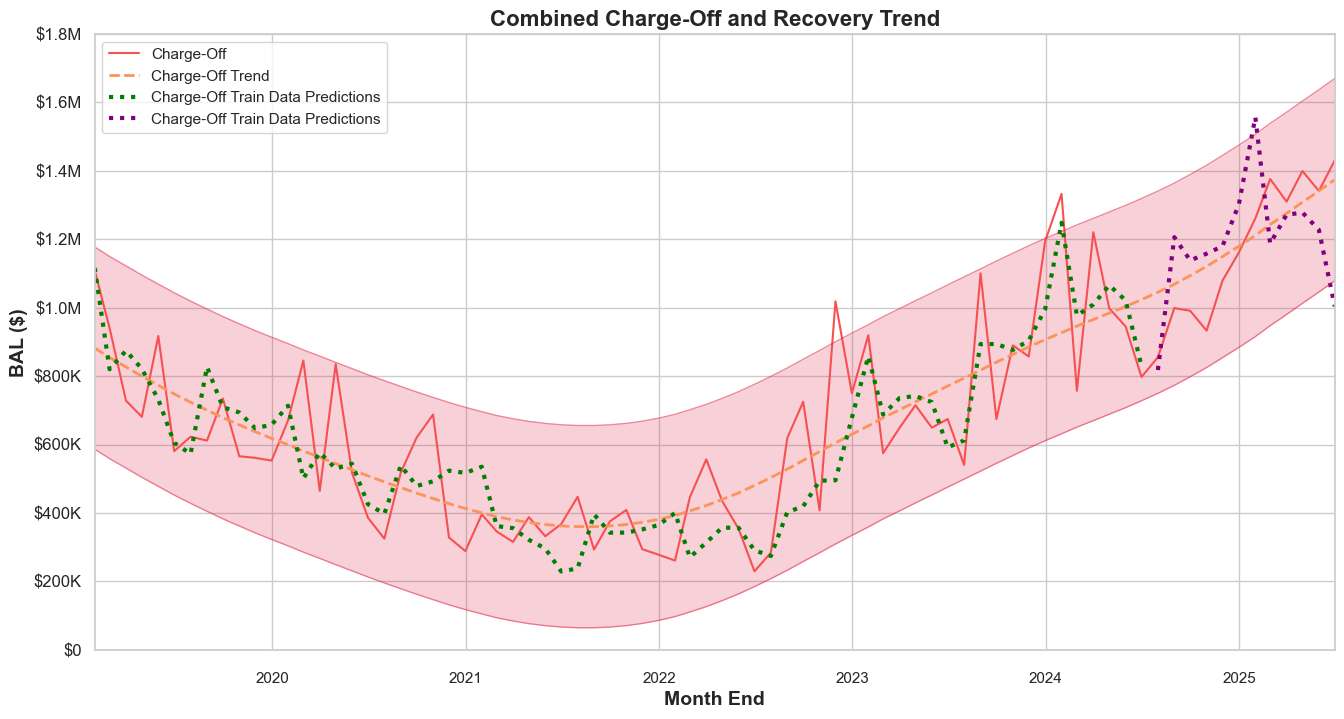

In [110]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Plot CO data
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL'], color='#f75050', label='Charge-Off')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2, label='Charge-Off Trend')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_train_forecast'], color='green', linestyle="dotted", lw=3, label='Charge-Off Train Data Predictions')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_test_forecast'], color='purple', linestyle="dotted", lw=3, label='Charge-Off Train Data Predictions')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend_upper'], color='crimson', alpha=0.5, lw=1)
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend_lower'], color='crimson', alpha=0.5, lw=1)
ax.fill_between(core_forecast_data.index.values, core_forecast_data['CO_BAL_trend_lower'], core_forecast_data['CO_BAL_trend_upper'], facecolor='crimson', alpha=0.2)

ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', size=12)
plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('Combined Charge-Off and Recovery Trend', size=16, fontweight='bold')
plt.show();

#### Train Test on HP Filter trend

In [111]:
# Split your data
train_data_co, test_data_co = train_test_split_ts(core_forecast_data['CO_BAL_trend'], test_size=12)

print(f"Train period: {train_data_co.index[0]} to {train_data_co.index[-1]}")
print(f"Test period: {test_data_co.index[0]} to {test_data_co.index[-1]}")
print(f"Train size: {len(train_data_co)} months")
print(f"Test size: {len(test_data_co)} months")

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months


In [112]:
fitted_model = ExponentialSmoothing(
    train_data_co,
    trend='add',           # Additive trend
    seasonal='mul',        # Multiplicative seasonality
    damped_trend=True,     # Damped trend
    seasonal_periods=12    # Monthly seasonality
)

# Fit with your best fitting parameters (use the ones that gave best results)
fitted_model = fitted_model.fit(
    optimized=True,
           # Let it optimize smoothing parameters
)

In [113]:
fitted_values = fitted_model.fittedvalues

In [114]:
core_forecast_data = core_trend_data.merge(pd.DataFrame(fitted_values, columns=['CO_BAL_trend_train_forecast']), how='left', left_index=True, right_index=True)

In [115]:
# Calculate in-sample metrics using sklearn
train_mae = mean_absolute_error(train_data_co, fitted_values)
train_rmse = np.sqrt(mean_squared_error(train_data_co, fitted_values))
train_mse = mean_squared_error(train_data_co, fitted_values)

# MAPE you'll still need to calculate manually (not in sklearn)
train_mape = np.mean(np.abs((train_data_co - fitted_values) / train_data_co)) * 100

print(f"In-Sample Performance:")
print(f"MAE: ${train_mae:,.0f}")
print(f"MSE: ${train_mse:,.0f}")
print(f"RMSE: ${train_rmse:,.0f}")
print(f"MAPE: {train_mape:.2f}%")

# R-squared
train_r2 = r2_score(train_data_co, fitted_values)
print(f"R-squared: {train_r2:.3f}")

In-Sample Performance:
MAE: $869
MSE: $1,379,478
RMSE: $1,175
MAPE: 0.19%
R-squared: 1.000


In [116]:
forecast_periods = len(test_data_co)
forecast = fitted_model.forecast(forecast_periods)

# Calculate in-sample metrics using sklearn
test_mae = mean_absolute_error(test_data_co, forecast)
test_rmse = np.sqrt(mean_squared_error(test_data_co, forecast))
test_mse = mean_squared_error(test_data_co, forecast)

# MAPE you'll still need to calculate manually (not in sklearn)
test_mape = np.mean(np.abs((test_data_co - forecast) / test_data_co)) * 100

print(f"In-Sample Performance:")
print(f"MAE: ${test_mae:,.0f}")
print(f"MSE: ${test_mse:,.0f}")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"MAPE: {test_mape:.2f}%")

# R-squared
test_r2 = r2_score(test_data_co, forecast)
print(f"R-squared: {test_r2:.3f}")

In-Sample Performance:
MAE: $47,331
MSE: $3,784,691,573
RMSE: $61,520
MAPE: 3.69%
R-squared: 0.655


In [117]:
core_forecast_data = core_forecast_data.merge(pd.DataFrame(forecast, columns=['CO_BAL_trend_test_forecast']), how='left', left_index=True, right_index=True)

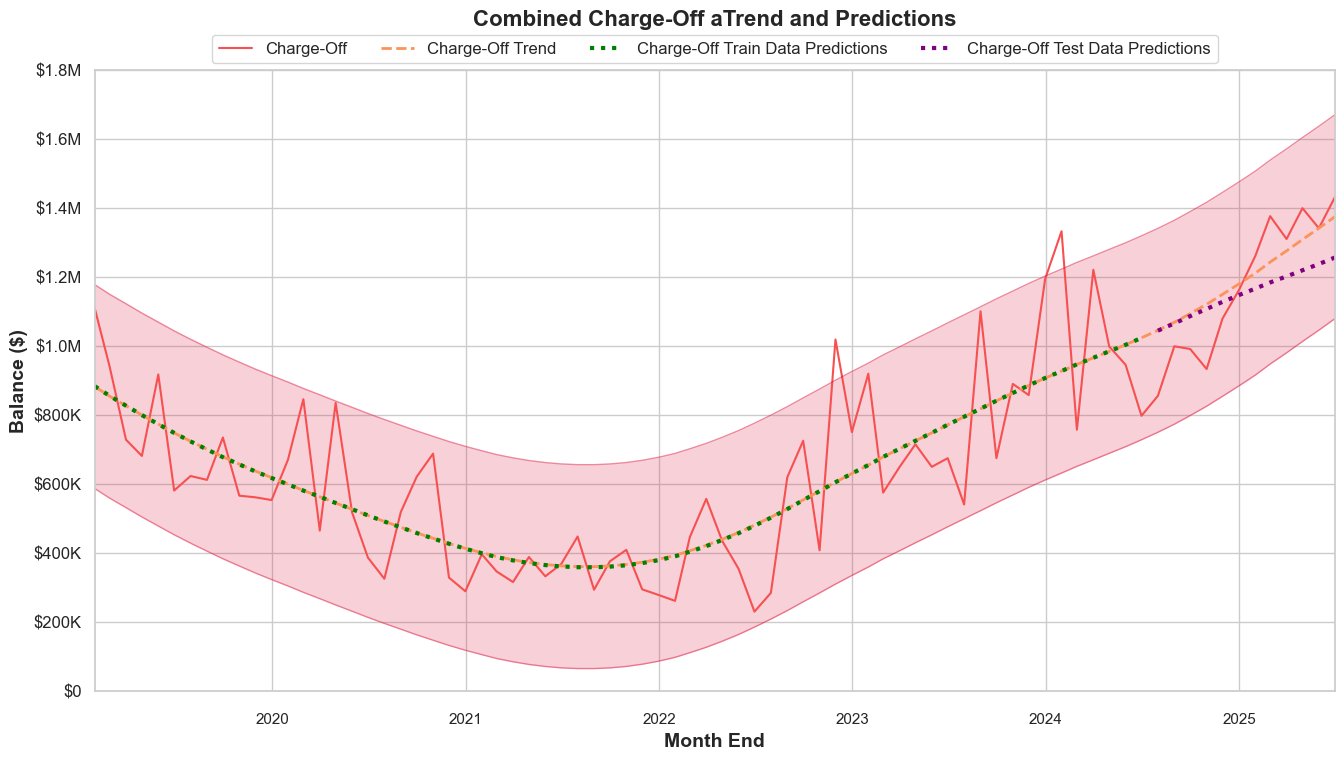

In [118]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,9))  # Changed this line

plt.title('Combined Charge-Off aTrend and Predictions', size=16, fontweight='bold', pad=32)  # Add pad for spacing

# Plot CO data
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL'], color='#f75050', label='Charge-Off')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2, label='Charge-Off Trend')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend_train_forecast'], color='green', linestyle="dotted", lw=3, label='Charge-Off Train Data Predictions')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend_test_forecast'], color='purple', linestyle="dotted", lw=3, label='Charge-Off Test Data Predictions')
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend_upper'], color='crimson', alpha=0.5, lw=1)
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_trend_lower'], color='crimson', alpha=0.5, lw=1)
ax.fill_between(core_forecast_data.index.values, core_forecast_data['CO_BAL_trend_lower'], core_forecast_data['CO_BAL_trend_upper'], facecolor='crimson', alpha=0.2)

ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Balance ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000, 1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', size=12)
#plt.legend(loc=0, fontsize=12)
# Position legend between title and plot
plt.legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=4, fontsize=12)
plt.subplots_adjust(top=0.80)  # Make more room at the top
plt.ylim(0, 1800000)

plt.show();

#### Recovery Predictions

In [119]:
rec_train_data, rec_test_data = split_data(core_forecast_data, 'REC_BAL', 12)
core_forecast_data, rec_train_fitted_model, mae, rmse, mse, mape, r2 = fit_model(rec_train_data,'mul', 'mul', True, True, core_forecast_data, core_forecast_data, 'REC_BAL_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months

In-Sample Performance:
MAE: $46,744
MSE: $4,220,214,093
RMSE: $64,963
MAPE: 25.26%
R-squared: 0.308


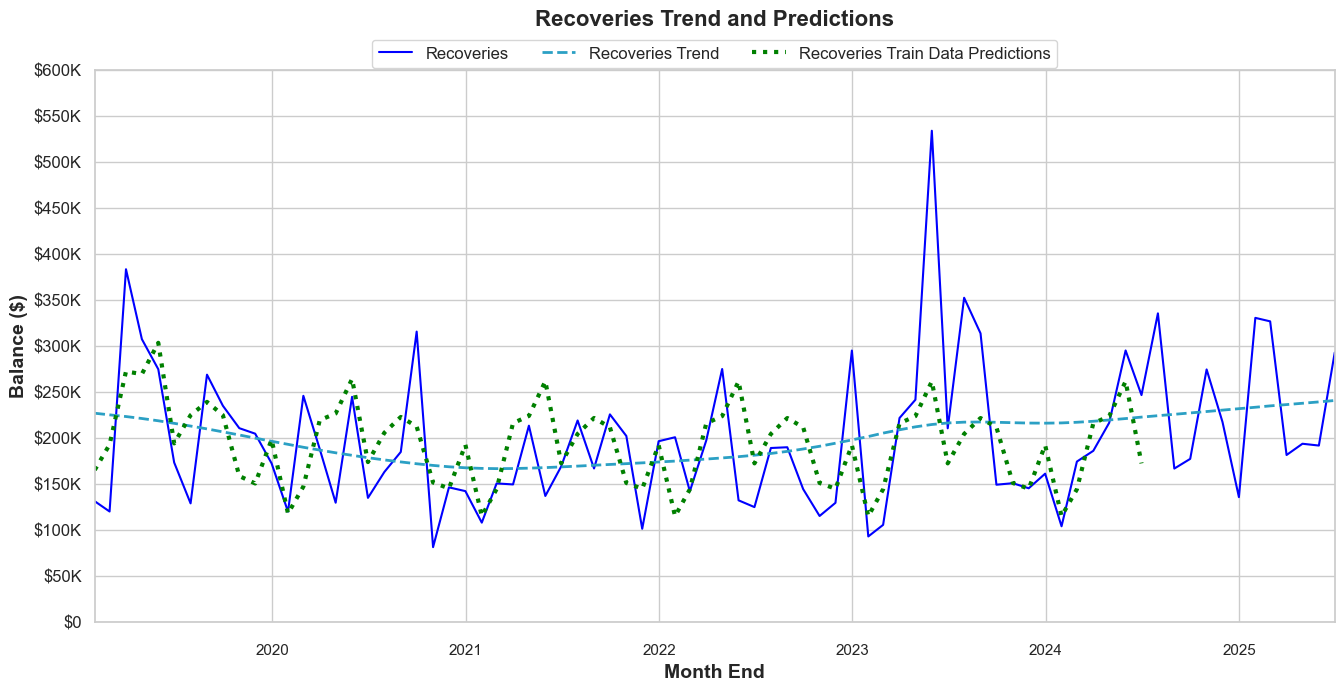

In [120]:
title = 'Recoveries Trend and Predictions'
yticks = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]
yticks_labels = ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']
plot_data(title, core_forecast_data, 'REC', 'Recoveries', 3, max(yticks), yticks, yticks_labels, 
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

In [121]:
# Testing a different model for better predictions
core_forecast_data, rec_test_fitted_model, mae, rmse, mse, mape, r2 = fit_model(rec_train_data,'add', 'add', True, True, core_forecast_data, core_forecast_data, 'REC_BAL_train_forecast_ignore')

In [122]:
core_forecast_data.drop(columns=['REC_BAL_train_forecast_ignore'], inplace=True)

In [123]:
core_forecast_data = forecast_data(rec_test_fitted_model, core_forecast_data, rec_test_data, 'REC', trend=False)

📊 STABLE RECOVERY FORECAST RESULTS:
Actual mean: $235,292
Stable forecast mean: $190,082
Ratio: 0.81x
MAPE: 36.45%
R²: -1.451


In [124]:
core_forecast_data.columns

Index(['CO_BAL', 'REC_BAL', 'ratio', 'year', 'CO_BAL_trend',
       'CO_BAL_trend_upper', 'CO_BAL_trend_lower', 'REC_BAL_trend',
       'REC_BAL_trend_upper', 'REC_BAL_trend_lower',
       'CO_BAL_trend_train_forecast', 'CO_BAL_trend_test_forecast',
       'REC_BAL_train_forecast', 'REC_BAL_test_forecast'],
      dtype='object')

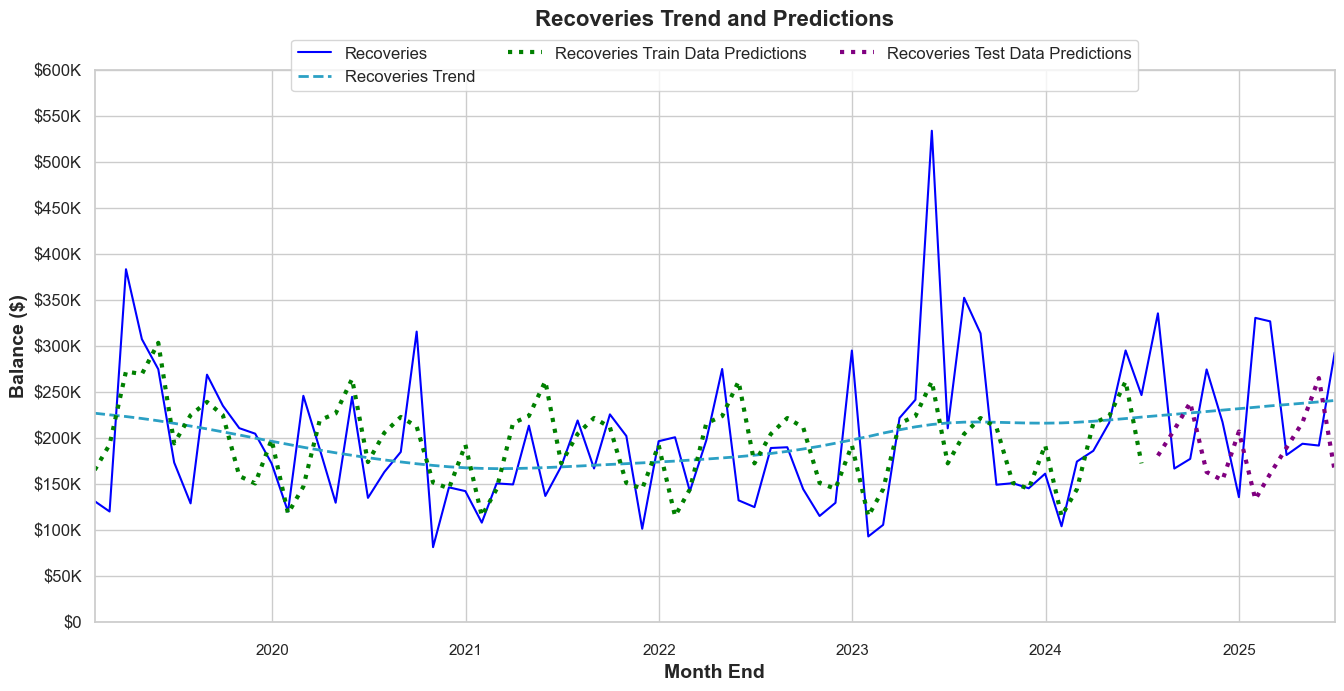

In [125]:
title = 'Recoveries Trend and Predictions'
yticks = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]
yticks_labels = ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']
plot_data(title, core_forecast_data, 'REC', 'Recoveries', 3, max(yticks), yticks, yticks_labels, 
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=True, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

Train Recovery Data on Hp Filter

In [126]:
rec_trend_train_data, rec_trend_test_data = split_data(core_forecast_data, 'REC_BAL_trend', 12)
core_forecast_data, rec_trend_train_fitted_model, mae, rmse, mse, mape, r2 = fit_model(rec_trend_train_data,'add', 'mul', True, True, core_forecast_data, core_forecast_data, 'REC_BAL_trend_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months

In-Sample Performance:
MAE: $235
MSE: $76,539
RMSE: $277
MAPE: 0.12%
R-squared: 1.000


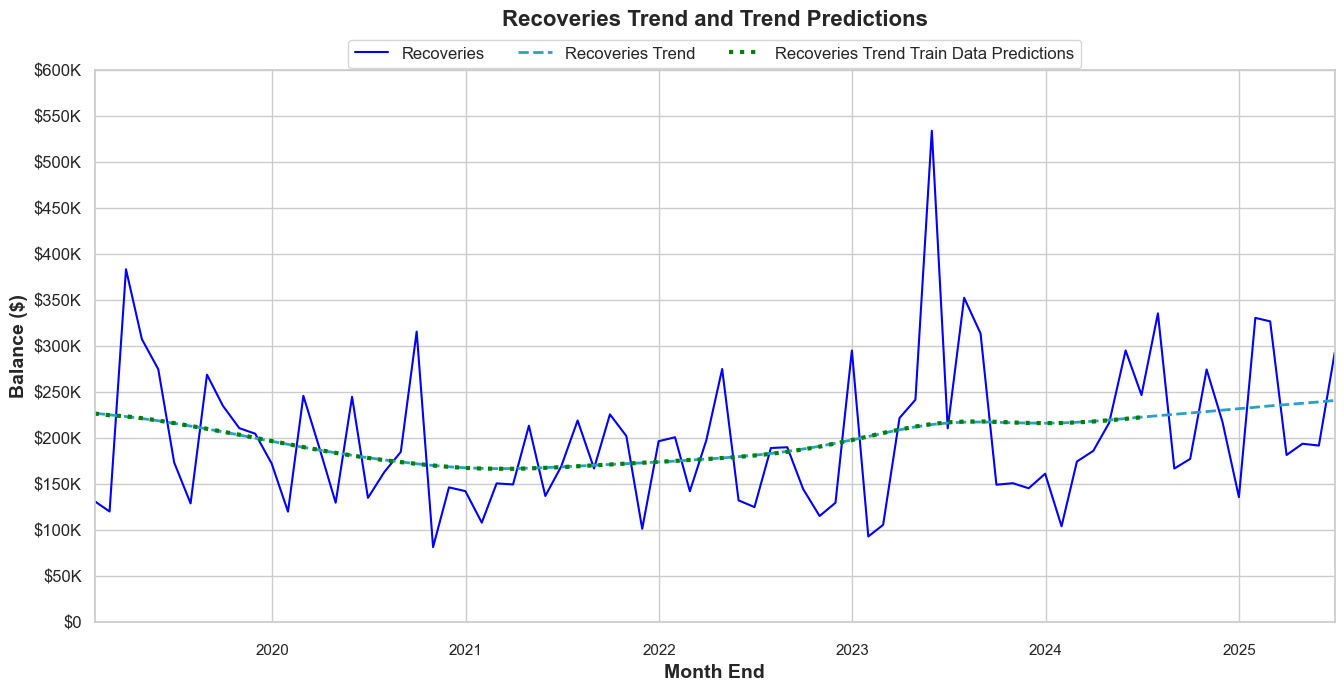

In [127]:
title = 'Recoveries Trend and Trend Predictions'
yticks = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]
yticks_labels = ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']
plot_data(title, core_forecast_data, 'REC', 'Recoveries', 3, max(yticks), yticks, yticks_labels, 
              actual_data=True, trend_data=True, train_forecast=False, test_forecast=False, trend_train_forecast=True, trend_test_forecast=False, trend_ci=False)

In [128]:
core_forecast_data = forecast_data(rec_trend_train_fitted_model, core_forecast_data, rec_trend_test_data, 'REC', trend=True)

📊 STABLE RECOVERY FORECAST RESULTS:
Actual mean: $232,460
Stable forecast mean: $230,944
Ratio: 0.99x
MAPE: 0.65%
R²: 0.899


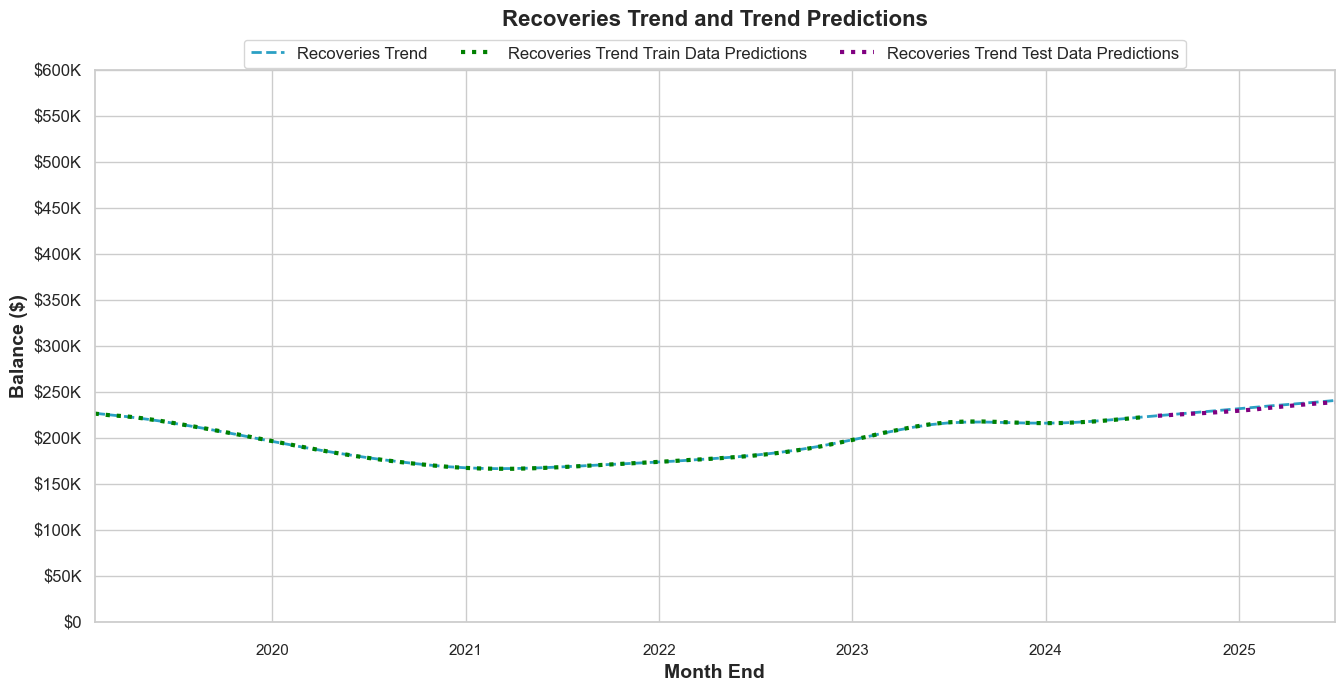

In [130]:
title = 'Recoveries Trend and Trend Predictions'
yticks = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]
yticks_labels = ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']
plot_data(title, core_forecast_data, 'REC', 'Recoveries', 3, max(yticks), yticks, yticks_labels, 
              actual_data=False, trend_data=True, train_forecast=False, test_forecast=False, trend_train_forecast=True, trend_test_forecast=True, trend_ci=False)